In [4]:
import numpy as np
#from matplotlib import pyplot as plt
#%matplotlib inline
#plt.rcParams.update({'font.size': 16, 'figure.figsize':(8,6)})

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'xx-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt

In [5]:
def plot_training(statistic, res_dir, data_dir, errtag='', subsample=None, version=None, nbins=9, test=False):
    plt.figure(figsize=(10,8)) 
    ps = []

    CC = range(0, 40)
    #CC = range(0,1)
    #HH = np.loadtxt("../CMASS/Gaussian_Process/GP/HOD_random_subsample_{}_version_{}.dat".format(subsample, version))
    #HH = np.atleast_2d(HH[0][:3])
    nhodnonolap = 100
    nhodpercosmo = 100
    #nhodpercosmo = 1
    HH = np.array(range(0,len(CC)*nhodnonolap))
    HH  = HH.reshape(len(CC), nhodnonolap)
    HH = HH[:,0:nhodpercosmo]
    
    if errtag:
        GP_error = np.loadtxt(f"{res_dir}/{statistic}_error{errtag}.dat")
    
    #color_idx = np.linspace(0, 1, np.max(HH)+1)
    color_idx = np.linspace(0, 1, len(CC))

    for cosmo in CC:
        HH_set = HH[cosmo]
        for hod in HH_set:
            zz = np.random.randint(len(HH.flatten()))
            hod = int(hod)
            color=plt.cm.rainbow(color_idx[cosmo])
            if test:
                for box in range(0,5):
                    fn = '{}/{}_cosmo_{}_Box_{}_HOD_{}_test_0.dat'.format(data_dir, statistic, cosmo, box, hod)
                    r, p = np.loadtxt(fn, delimiter=',',unpack=True)
                    if errtag:
                        plt.errorbar(r[:nbins], p[:nbins], yerr=GP_error[:nbins], lw=0.5, elinewidth=1, capsize=1, color=color, 
                                     zorder=zz)
                    else:
                        plt.plot(r[:nbins], p[:nbins], color=color, lw=0.5, zorder=zz)
            else:
                fn = '{}/{}_cosmo_{}_HOD_{}_test_0.dat'.format(data_dir, statistic, cosmo, hod)
                r, p = np.loadtxt(fn, delimiter=',',unpack=True)
                if errtag:
                    plt.errorbar(r[:nbins], p[:nbins], yerr=GP_error[:nbins], lw=0.5, elinewidth=1, capsize=1, color=color, 
                                 zorder=zz)
                else:
                    plt.plot(r[:nbins], p[:nbins], color=color, lw=0.5, zorder=zz)
                
    plt.yscale("log")
    plt.xlabel("r (Mpc/h)") #is it? are positions in Mpc? not h?
    
    if statistic == 'upf':
        plt.ylabel(r"P$_U$(r)")
        
    elif statistic == 'wp':
        plt.ylabel(r'$w_p$($r_p$)')
        plt.xscale('log')

In [6]:
def plot_accuracy(statistic, testtag, acctag, hod=None, subsample=None, version=None, errtag=None, nbins=9, remove=None,
                 plot_wrt_mean=False, highlight=None, nhods=100, err_as_percentiles=False):
    
    if plot_wrt_mean:
        ncols = 4
    else:
        ncols = 3
    fig, ax = plt.subplots(ncols, 1, figsize=(10,15), gridspec_kw={'height_ratios': [1]*ncols})
    plt.subplots_adjust(hspace=0.15)

    CC_test = range(0, 7)
    HH_test = range(0, nhods)
    if remove:
        for rval in remove:
            #HH_test.remove(rval)
            CC_test.remove(rval)
    #HH_test = np.array([0,1,2,3,4,6,7,8,9])
    #HH_test = [0, 6, 10, 11, 14, 16, 19, 20, 23, 24]#, 25, 26, 27, 28, 29, 32, 33, 38, 41, 43, 44, 47, 
               #50, 52, 57, 58, 59, 60, 64, 68, 71, 72, 74, 75, 77, 81, 82, 83, 84, 85, 87, 91, 97, 99] #good hods  
    upf_mean = np.zeros(nbins)
    
    res_dir = '../../clust/results_{}/'.format(statistic)
    
    if errtag:
        GP_error = np.loadtxt(res_dir+"{}_error{}.dat".format(statistic, errtag))
        GP_error_p16 = np.loadtxt(res_dir+"{}_p16{}.dat".format(statistic, errtag))
        GP_error_p84 = np.loadtxt(res_dir+"{}_p84{}.dat".format(statistic, errtag))

    
    for cosmo in CC_test:
        for hod in HH_test:
            hod = int(hod)
            if "mean" in acctag:
                idtag = '{}_cosmo_{}_HOD_{}_mean'.format(statistic, cosmo, hod)
            else:
                idtag = '{}_cosmo_{}_Box_0_HOD_{}_test_0'.format(statistic, cosmo, hod)
            #fnt = '../testing_results/tests_{}{}/{}.dat'.format(statistic, acctag, idtag)
            fnt = '{}testing_{}{}/{}.dat'.format(res_dir, statistic, testtag, idtag)


            ntest, ptest = np.loadtxt(fnt)
            upf_mean += ptest[:nbins]

    print('radii:', ntest)
    if errtag:
        print("Training error:", GP_error)
        
    upf_mean /= len(CC_test)*len(HH_test)
    #print "mean:",upf_mean    
    #color_idx = np.linspace(0, 1, len(CC_test)*len(HH_test))
    color_idx = np.linspace(0, 1, len(HH_test))

    i = 0
    fracerrs = []

    for cosmo in CC_test:
        colidx = 0
        for hod in HH_test:
            hod = int(hod)
            color=plt.cm.rainbow(color_idx[colidx])
            colidx += 1
            if "mean" in acctag:
                idtag = '{}_cosmo_{}_HOD_{}_mean'.format(statistic, cosmo, hod)
            else:
                idtag = '{}_cosmo_{}_Box_0_HOD_{}_test_0'.format(statistic, cosmo, hod)
            #fnt = '../testing_results/tests_{}{}/{}.dat'.format(statistic, acctag, idtag)
            fnt = '{}testing_{}{}/{}.dat'.format(res_dir, statistic, testtag, idtag)

            lw = 1
            zorder = None
            if highlight is not None:
                alpha = 0.2
                cosmo_hl, hod_hl = highlight
                if cosmo==cosmo_hl and hod==hod_hl:
                    lw = 3
                    zorder = 1000
                    alpha = 1.0
            else:
                alpha = 1.0
                    
            ntest, ptest = np.loadtxt(fnt)
            if i==0:
                ax[0].semilogy(ntest[:nbins], ptest[:nbins], marker='o', ls='None', markerfacecolor='None', markeredgecolor=color, lw=lw, zorder=zorder, alpha=alpha, label='testbox (actual)')
            else:
                ax[0].semilogy(ntest[:nbins], ptest[:nbins], marker='o', ls='None', markerfacecolor='None', markeredgecolor=color, lw=lw, zorder=zorder, alpha=alpha)

            
            fnp = '../testing_results/predictions_{}{}/{}.dat'.format(statistic, acctag, idtag)
            npredic, ppredic = np.loadtxt(fnp, delimiter=',', unpack=True)
            #ppredic = abs(ppredic)
            if i==0:
                ax[0].semilogy(npredic[:nbins], ppredic[:nbins], marker=None, ls='-', color=color, lw=lw, alpha=alpha, label='emulator prediction')
            else: 
                ax[0].semilogy(npredic[:nbins], ppredic[:nbins], marker=None, ls='-', color=color, lw=lw, alpha=alpha)
            
            idx_err = 1
            if plot_wrt_mean:
                ax[1].plot(ntest[:nbins], ptest[:nbins]/upf_mean[:nbins], marker='o', ls='None', lw=lw, alpha=alpha, markerfacecolor='None', markeredgecolor=color)
                ax[1].plot(npredic[:nbins], ppredic[:nbins]/upf_mean[:nbins], marker=None, ls='-', lw=lw, alpha=alpha, color=color)
                idx_err = 2

            fracerr = (ppredic-ptest)/ptest
            # PRINT BAD
            if fracerr[8]>1:
                print(cosmo, hod)
            fracerrs.append(fracerr)
            ax[idx_err].plot(ntest[:nbins], fracerr[:nbins], color=color, lw=lw, alpha=alpha)
            #ax1.plot(ntest, ppredic/ptest)
            i += 1

    fracerrs = np.array(fracerrs)
    
    std = np.std(fracerrs, axis=0)
    p16 = np.percentile(fracerrs, 16, axis=0)
    p84 = np.percentile(fracerrs, 84, axis=0)
    pavg = (np.percentile(fracerrs, 84, axis=0)-np.percentile(fracerrs, 16, axis=0))/2.0
    p68 = np.percentile(fracerrs, 68, axis=0)
    print("standard dev of fracerr:", std)

    if err_as_percentiles:
        p16 = np.percentile(fracerrs, 16, axis=0)
        p84 = np.percentile(fracerrs, 84, axis=0)
        ax[idx_err+1].plot(ntest[:nbins], p16[:nbins], color='b', ls='-', lw=2, label='')
        ax[idx_err+1].plot(ntest[:nbins], p84[:nbins], color='b', ls='-', lw=2, label='16/84 percentile')
        ax[idx_err+1].axhline(0, color='k', ls=':')
        #ax[idx_err+1].axhline(0.01, color='k', lw=0.5)
        #ax[idx_err+1].axhline(-0.01, color='k', lw=0.5)
        ax[idx_err+1].plot(ntest[:nbins], GP_error_p16[:nbins], color='r', lw=2, label='training set error')
        ax[idx_err+1].plot(ntest[:nbins], GP_error_p84[:nbins], color='r', lw=2)
    else:
        ax[idx_err+1].axhline(0, color='k', ls=':')
        #ax[idx_err+1].axhline(0.01, color='k', lw=0.5)
        ax[idx_err+1].plot(ntest[:nbins], std[:nbins], color='b', lw=2, ls='-', label='stdev of fractional error')
        ax[idx_err+1].plot(ntest[:nbins], GP_error[:nbins], color='r', lw=2, label='training set error')


    #ax[idx_err+1].plot(ntest[:nbins], p16[:nbins], color='cyan', ls='-', label='p16')
    #ax[idx_err+1].plot(ntest[:nbins], p84[:nbins], color='blue', ls='-', label='p84')
    #ax[idx_err+1].plot(ntest[:nbins], p68[:nbins], color='limegreen', ls='-', label='p68')
    #ax[idx_err+1].plot(ntest[:nbins], pavg[:nbins], color='orange', ls='-', label='pavg')
        

    ax[idx_err+1].set_yscale("log")
    ax[idx_err+1].set_ylabel("error")
    ax[idx_err+1].legend()
    
#     ax[idx_err+2].set_ylabel("fractional error")
#     ax[idx_err+2].legend()
    
    ax[0].legend()
                 
    if statistic == 'upf':
        ax[0].set_ylabel(r"P$_U$(r)")
        #ax[1].set_ylabel(r"P$_U$/P$_{U,mean}$")
        ax[idx_err].set_ylabel("fractional error")
        #ax[idx_err].set_ylabel(r"(P$_{emulator}$-P$_{true}$)/P$_{true}$")
        ax[idx_err+1].set_xlabel(r"$r$ ($h^{-1}$Mpc)")

    elif statistic == 'wp':
        ax[0].set_ylabel(r'$w_p$($r_p$)')
        #ax[1].set_ylabel(r"$w_p$/$w_{p,mean}$")
        ax[idx_err].set_ylabel(r"($w_{p,emu}$-$w_{p,true}$)/$w_{p,true}$")
        ax[idx_err].set_ylabel("fractional error")
        ax[idx_err+1].set_xlabel(r"$r$ ($h^{-1}$Mpc)")
        for nc in range(ncols):
            ax[nc].set_xscale('log')

radii: [ 5. 10. 15. 20. 25. 30. 35. 40. 45.]
Training error: [0.00026789 0.0014204  0.00452516 0.0076934  0.01624975 0.02818104
 0.04762237 0.10846196 0.19735825]
0 81
0 87
standard dev of fracerr: [0.00116636 0.00583435 0.00862095 0.01332051 0.02391077 0.03349207
 0.05186932 0.10321436 0.16006762]


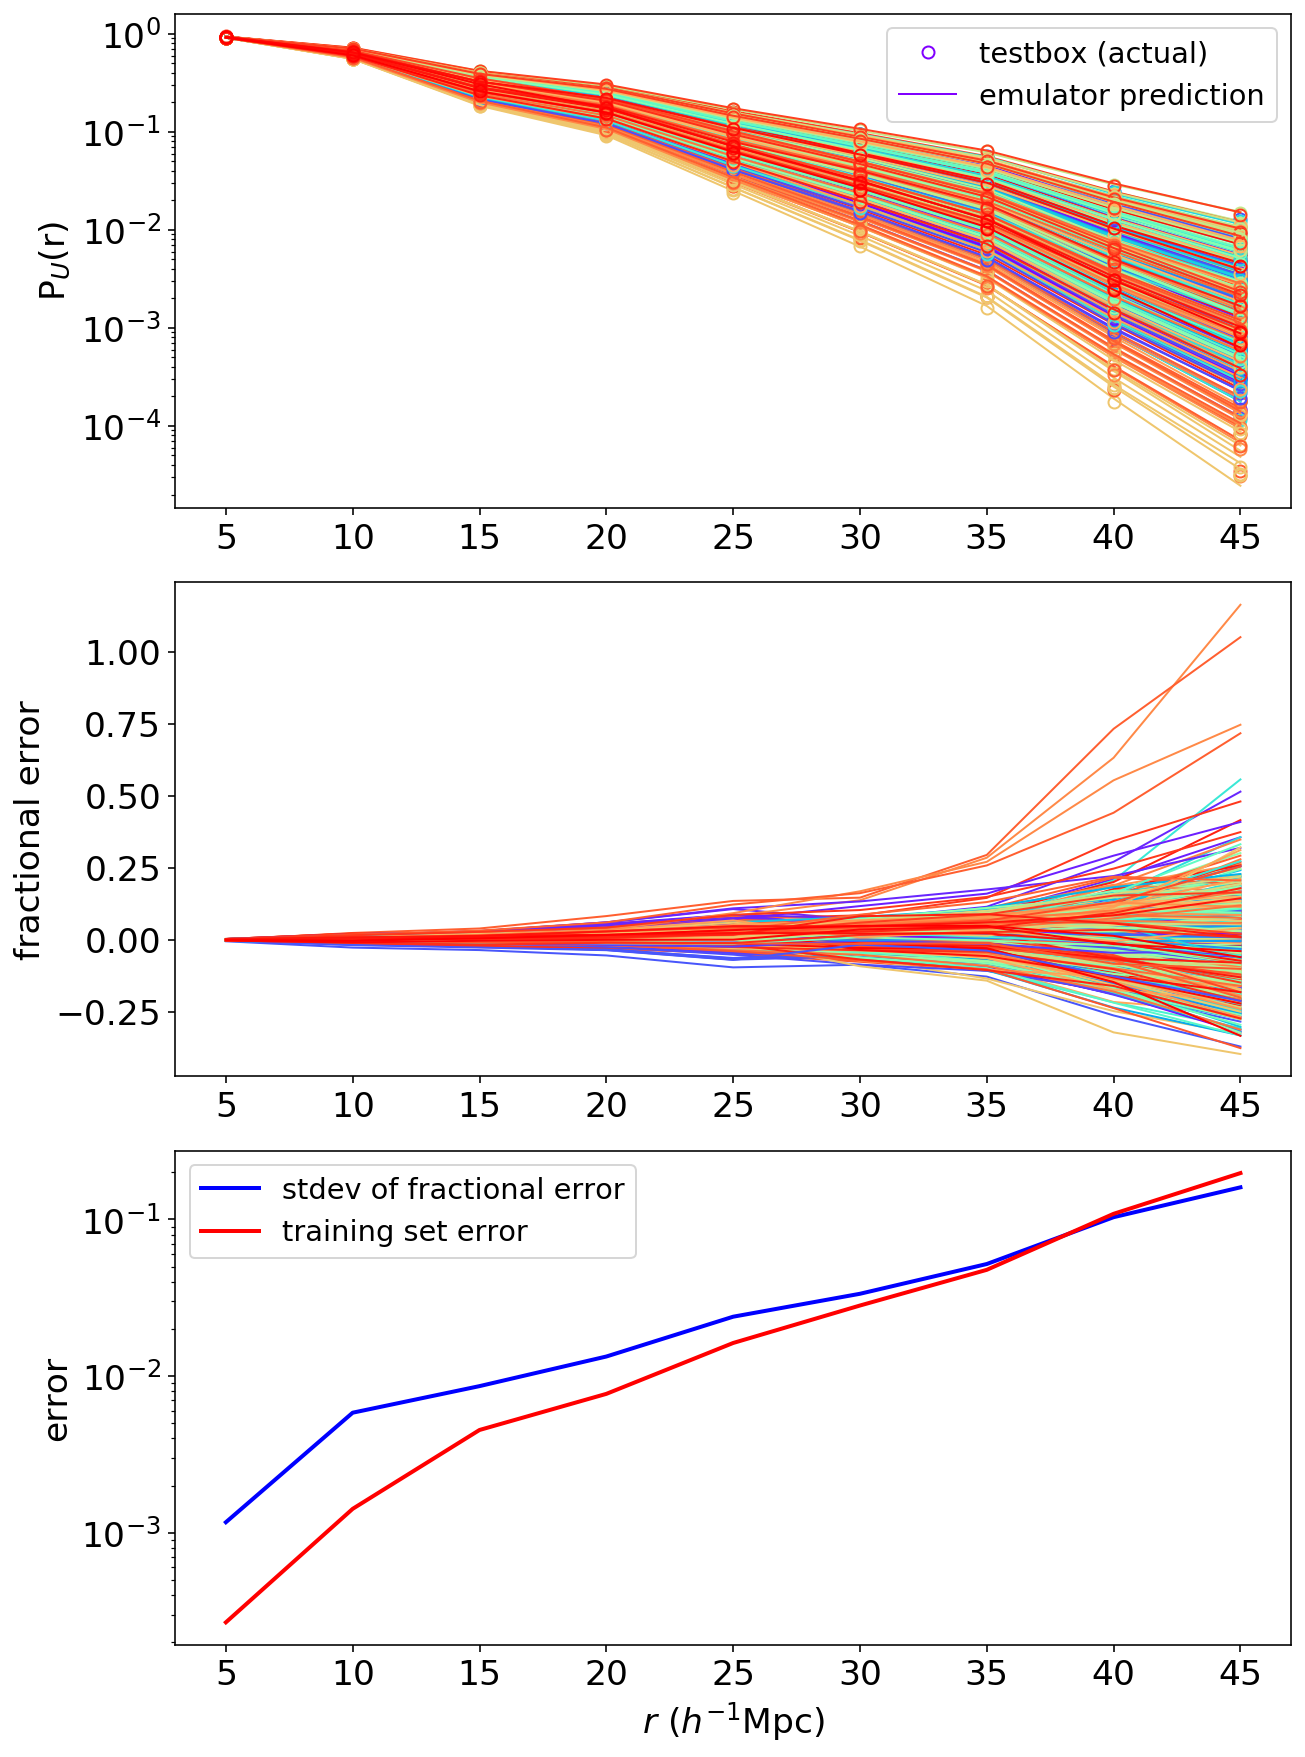

In [7]:
statistic='upf'
traintag = '_nonolap'
testtag = '_mean_test0'
errtag = '_hod3_test0'
tag = '_log_kM32ExpConst2_100hod'
gptag = traintag + errtag + tag
acctag = gptag + testtag
plot_accuracy(statistic, testtag, acctag, errtag=errtag, nbins=9, nhods=100)

In [ ]:
statistic='upf'
traintag = '_nonolap'
testtag = '_mean_test0'
errtag = '_hod3_test0'
tag = '_log_kM32ExpConst_100hod'
gptag = traintag + errtag + tag
acctag = gptag + testtag
plot_accuracy(statistic, testtag, acctag, errtag=errtag, nbins=9, nhods=100)

radii: [ 5. 10. 15. 20. 25. 30. 35. 40. 45.]
Training error: [0.00026789 0.0014204  0.00452516 0.0076934  0.01624975 0.02818104
 0.04762237 0.10846196 0.19735825]
0 81
0 87
standard dev of fracerr: [0.00135911 0.00291267 0.0056653  0.0097817  0.01960219 0.03336917
 0.05197282 0.10313455 0.16013978]
